<a href="https://colab.research.google.com/github/OVP2023/CV/blob/main/DZ_CV1_ver_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
#Решить задачу детекции на основе SSD

In [31]:
import torch
import torch.optim as optim
import torchvision
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
from torchvision.models.detection.ssd import SSDClassificationHead
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from typing import List
import os, sys, random
import xml.etree.ElementTree as ET
from glob import glob
from shutil import copyfile

In [32]:
#Считывание датасета
images=[]
boxes_list=[]
labels_list=[]
images_list=[]

annotations = glob('/content/drive/MyDrive/Datasets/BCCD_Dataset-master/BCCD/Annotations/*.xml')


for file in annotations:
    filename = '/content/drive/MyDrive/Datasets/BCCD_Dataset-master/BCCD/JPEGImages/'+file.split('/')[-1].split('.')[0] + '.jpg'

    boxes = []
    labels = []


    img = Image.open(filename).convert("RGB")
    images.append(img)
    img_np = np.array(img)

    parsedXML = ET.parse(file)
    for node in parsedXML.getroot().iter('object'):
        # Получение класса
        class_name = node.find('name').text
        if class_name == "RBC": label = int(1)
        elif class_name == "WBC": label = int(2)
        else: label = int(0)  # Platelets

        # Получение координат bounding box
        xmin = int(node.find('bndbox/xmin').text)
        xmax = int(node.find('bndbox/xmax').text)
        ymin = int(node.find('bndbox/ymin').text)
        ymax = int(node.find('bndbox/ymax').text)

        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label)

    boxes_list.append(boxes)
    labels_list.append(labels)
    images_list.append(img_np)

In [33]:
# Определение пользовательского датасета для данных в памяти
class InMemoryDataset(Dataset):
    def __init__(self, images: List[np.ndarray],
                 boxes: List[List[List[float]]],
                 labels: List[List[int]],
                 transforms=None):

        self.images = images
        self.boxes = boxes
        self.labels = labels
        self.transforms = transforms


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Изображение
        img_np = self.images[idx]
        img = Image.fromarray(img_np).convert("RGB")
        height, width = img_np.shape[:2]

        # Bounding boxes
        boxes = self.boxes[idx]
        labels = self.labels[idx]

        # Проверка и фильтрация невалидных боксов
        valid_boxes = []
        valid_labels = []
        for box, label in zip(boxes, labels):
            xmin, ymin, xmax, ymax = box
            # Нормализация координат
            xmin /= width
            ymin /= height
            xmax /= width
            ymax /= height

            if xmin < xmax and ymin < ymax and 0 <= xmin <= 1 and 0 <= ymin <= 1 and 0 <= xmax <= 1 and 0 <= ymax <= 1:
                valid_boxes.append([xmin, ymin, xmax, ymax])
                valid_labels.append(label)

        # Конвертация в тензоры
        if len(valid_boxes) == 0:
            box_tensor = torch.zeros((0, 4), dtype=torch.float32)
            label_tensor = torch.zeros(0, dtype=torch.int64)
        else:
            box_tensor = torch.tensor(valid_boxes, dtype=torch.float32)
            label_tensor = torch.tensor(valid_labels, dtype=torch.int64)

        target = {
            "boxes": box_tensor,
            "labels": label_tensor
        }

        # Применение трансформаций
        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target

In [62]:
# Классы для трансформаций
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class ToTensor:
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

class Resize:
    def __init__(self, size=(300, 300)):
        self.size = size

    def __call__(self, image, target):
        # Сохраняем оригинальные размеры для денормализации
        orig_size = image.size[::-1]  # (H, W)
        image = F.resize(image, self.size)

        return image, target

In [35]:
# Инициализация модели SSD
def create_model(num_classes=3, pretrained=True):
    weights = SSD300_VGG16_Weights.DEFAULT if pretrained else None
    model = ssd300_vgg16(weights=weights, trainable_backbone_layers=5)

    # Параметры для SSD300 с VGG16
    in_channels = [512, 1024, 512, 256, 256, 256]
    num_anchors = [4, 6, 6, 6, 4, 4]

    # Создаем новую классификационную голову
    model.head.classification_head = SSDClassificationHead(
        in_channels=in_channels,
        num_anchors=num_anchors,
        num_classes=num_classes
    )

    return model

In [36]:
# Функция для коллации батчей
def collate_fn(batch):
    return tuple(zip(*batch))

In [41]:
# Обучение
batch_size=4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
    # Создание датасета и загрузчика
transforms = Compose([Resize((300, 300)), ToTensor()])
dataset = InMemoryDataset(images_list, boxes_list, labels_list, transforms=transforms)
data_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2
   )

Using device: cuda


In [42]:
 # Инициализация модели
model = create_model(num_classes=3)
model.to(device)

    # Оптимизатор
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

    # Цикл обучения
num_epochs=10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    batch_count = 0

    for images, targets in data_loader:
            # Перенос изображений и целей на устройство
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward pass
        loss_dict = model(images, targets)

            # Расчет общего лосса
        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses.item()
        batch_count += 1

            # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs} | Batch {batch_count}/{len(data_loader)} | Loss: {losses.item():.4f}")

    avg_loss = total_loss / batch_count
    print(f"Epoch [{epoch+1}/{num_epochs}] Avg Loss: {avg_loss:.4f}")

    # Сохранение модели
torch.save(model.state_dict(), 'ssd_model_in_memory.pth')
print("Training complete! Model saved.")


Epoch 1/10 | Batch 91/91 | Loss: 1.0872
Epoch [1/10] Avg Loss: 11.8097
Epoch 2/10 | Batch 91/91 | Loss: 1.9911
Epoch [2/10] Avg Loss: 2.1093
Epoch 3/10 | Batch 91/91 | Loss: 0.7291
Epoch [3/10] Avg Loss: 2.0186
Epoch 4/10 | Batch 91/91 | Loss: 0.7986
Epoch [4/10] Avg Loss: 1.9971
Epoch 5/10 | Batch 91/91 | Loss: 3.2144
Epoch [5/10] Avg Loss: 1.9637
Epoch 6/10 | Batch 91/91 | Loss: 1.9720
Epoch [6/10] Avg Loss: 1.9468
Epoch 7/10 | Batch 91/91 | Loss: 3.1582
Epoch [7/10] Avg Loss: 1.9584
Epoch 8/10 | Batch 91/91 | Loss: 3.0611
Epoch [8/10] Avg Loss: 1.9164
Epoch 9/10 | Batch 91/91 | Loss: 1.7365
Epoch [9/10] Avg Loss: 1.9161
Epoch 10/10 | Batch 91/91 | Loss: 7.2384
Epoch [10/10] Avg Loss: 1.9300
Training complete! Model saved.


In [43]:
# Функция для визуализации предсказаний
def visualize_prediction(image, boxes, labels, scores=None, threshold=0.5):
    fig, ax = plt.subplots(1, figsize=(12, 8))
    image = image.permute(1, 2, 0).cpu().numpy()
    ax.imshow(image)

    for i in range(len(boxes)):
        if scores is not None and scores[i] < threshold:
            continue

        box = boxes[i]
        label = labels[i]
        xmin, ymin, xmax, ymax = box

        # Денормализация координат
        height, width = image.shape[:2]
        xmin = xmin * width
        ymin = ymin * height
        xmax = xmax * width
        ymax = ymax * height

        rect = patches.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            linewidth=2,
            edgecolor='r',
            facecolor='none'
        )
        ax.add_patch(rect)

        if label == 1: class_name = "RBC"
        elif label == 2: class_name = "WBC"
        else: class_name = "Platelets"

        plt.text(xmin, ymin - 10,f"{class_name} ", color='red', fontsize=12)    #f"{class_name} "


    plt.axis('off')
    plt.show()

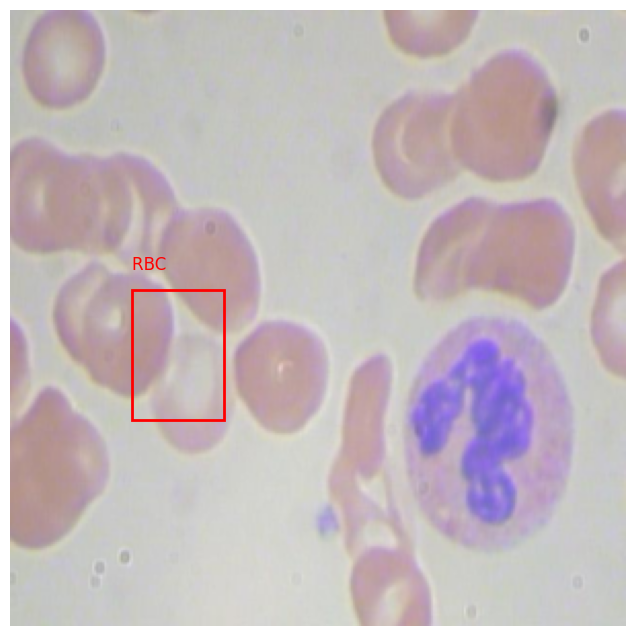

In [60]:
# Предсказание

model.eval()
with torch.no_grad():
    # Выбираем тестовое изображение
    test_img, test_target = dataset[0]

    #Предсказание
    prediction = model([test_img.to(device)])



    # Визуализация
    visualize_prediction(test_img, prediction[0]["boxes"].cpu(),prediction[0]["labels"].cpu(),prediction[0]["scores"].cpu())

In [57]:
prediction

[{'boxes': tensor([[0.1971, 0.4536, 0.3463, 0.6644],
          [0.1971, 0.4536, 0.3463, 0.6644]], device='cuda:0'),
  'scores': tensor([0.9401, 0.0526], device='cuda:0'),
  'labels': tensor([1, 2], device='cuda:0')}]